In [1]:
from random import randint

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchaudio.datasets import SPEECHCOMMANDS

from lcapt.analysis import make_feature_grid
from lcapt.lca import LCAConv1D
from lcapt.metric import compute_l1_sparsity, compute_l2_error

In [23]:
BATCH_SIZE = 64
EPOCHS = 20
FEATURES = 64
KERNEL_SIZE = 256
LAMBDA = 0.5
LCA_ITERS = 1000
PRINT_FREQ = 10
STRIDE = 4
TAU = 200

In [3]:
def cut_samples_and_combine(batch):
    audio = [sample[0][:, ::2] for sample in batch]
    crop_points = [randint(0, wave.numel() - 512) for wave in audio]
    audio = [wave[:, crop : crop + 512] for wave, crop in zip(audio, crop_points)]
    return torch.stack(audio)

In [4]:
dset = SPEECHCOMMANDS(".", download=True)

dataloader = DataLoader(
    dset, BATCH_SIZE, True, num_workers=4, drop_last=True, collate_fn=cut_samples_and_combine
)

In [5]:
lca = LCAConv1D(
    FEATURES,
    1,
    "./lca_speech_commands",
    KERNEL_SIZE,
    STRIDE,
    pad="valid",
    tau=TAU,
    lambda_=LAMBDA,
    track_metrics=False,
    return_vars=['inputs', 'acts', 'recons', 'recon_errors']
)
if torch.cuda.is_available():
    lca = nn.DataParallel(lca).cuda()

In [ ]:
for epoch in range(EPOCHS):
    for batch_num, batch in enumerate(dataloader):
        batch = batch.cuda()
        inputs, code, recon, recon_error = lca(batch)
        lca.module.update_weights(code, recon_error)
        if batch_num % PRINT_FREQ == 0:
            l1_sparsity = compute_l1_sparsity(code, lca.module.lambda_).item()
            l2_recon_error = compute_l2_error(inputs, recon).item()
            total_energy = l2_recon_error + l1_sparsity
            print(f'L2 Recon Error: {round(l2_recon_error, 2)}; ',
                  f'L1 Sparsity: {round(l1_sparsity, 2)}; ',
                  f'Total Energy: {round(total_energy, 2)}')
    torch.save(lca, f'save_{epoch}.pth')

In [31]:
weight_grid = make_feature_grid(lca.module.get_weights())

In [32]:
weight_grid.shape

torch.Size([64, 256])

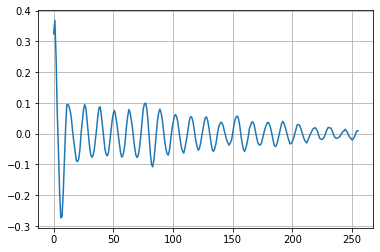

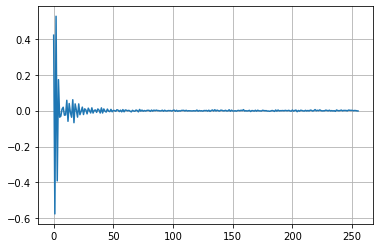

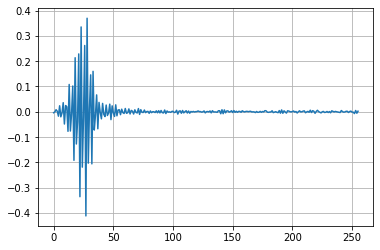

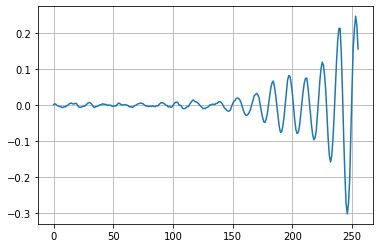

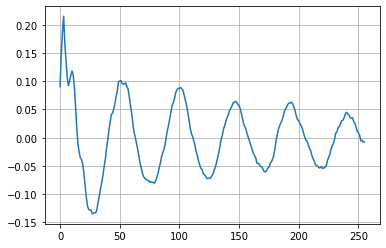

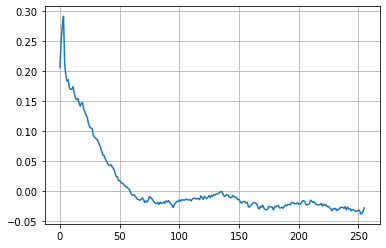

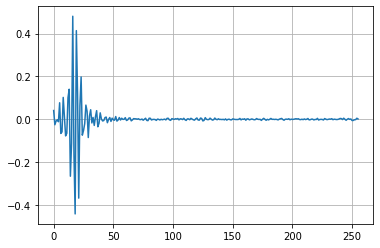

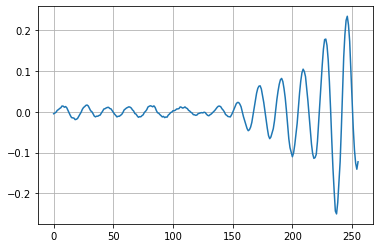

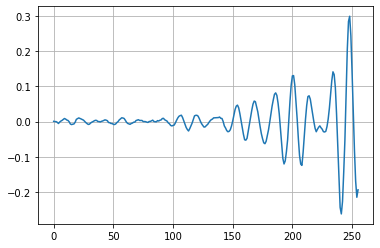

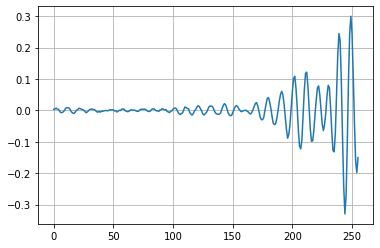

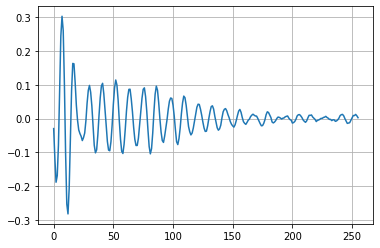

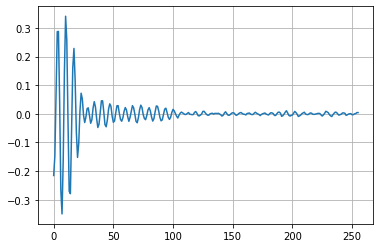

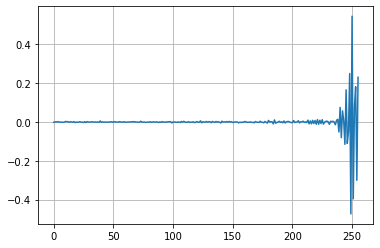

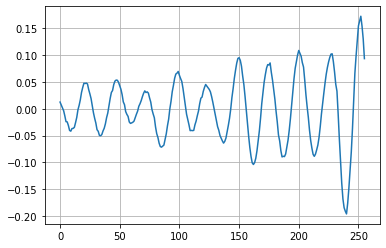

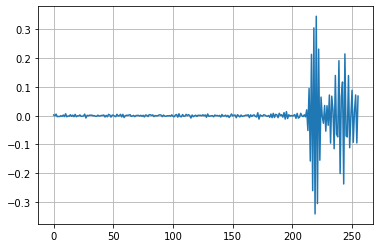

In [33]:
for i in range(15):
    plt.plot(weight_grid[i].cpu().numpy())
    plt.grid()
    plt.show()
    plt.close()

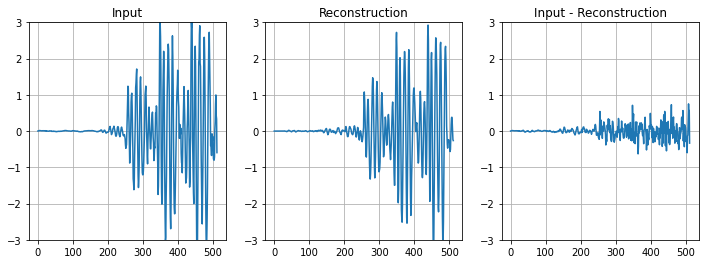

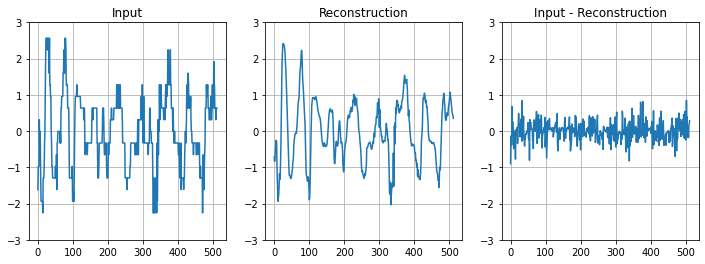

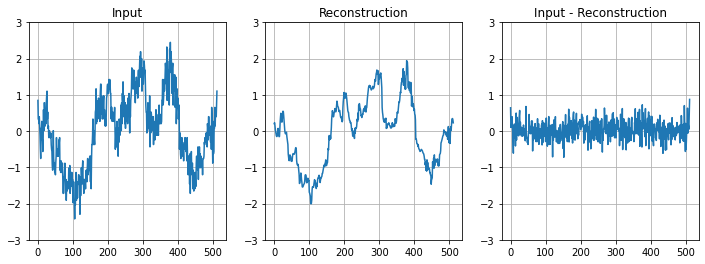

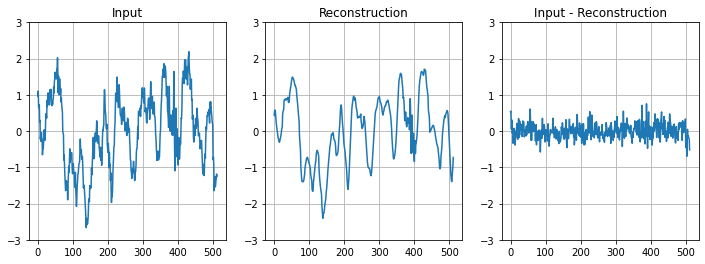

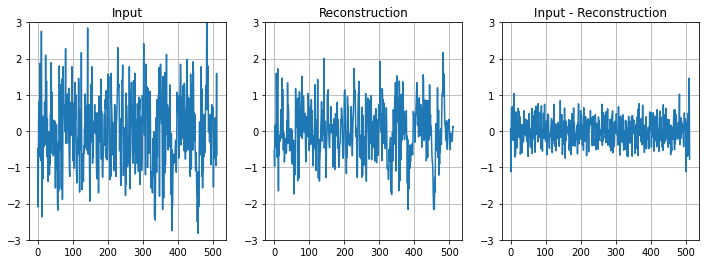

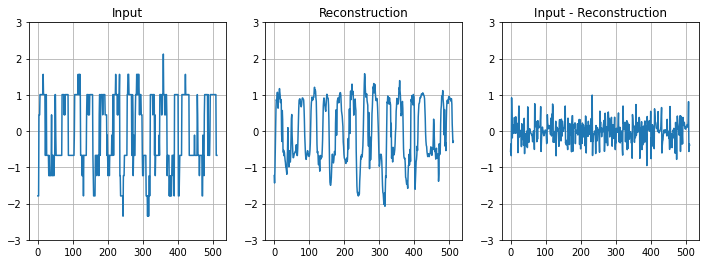

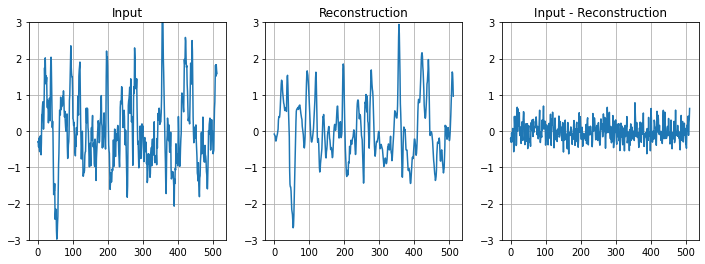

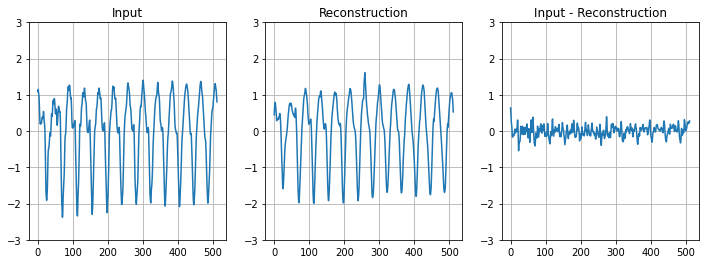

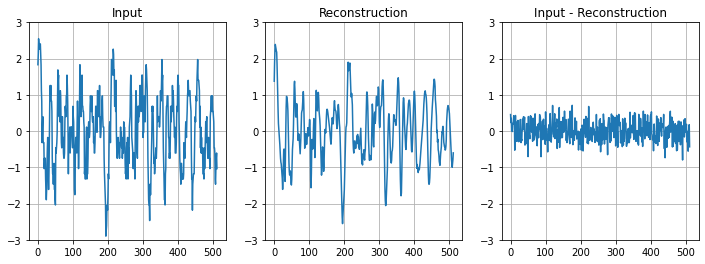

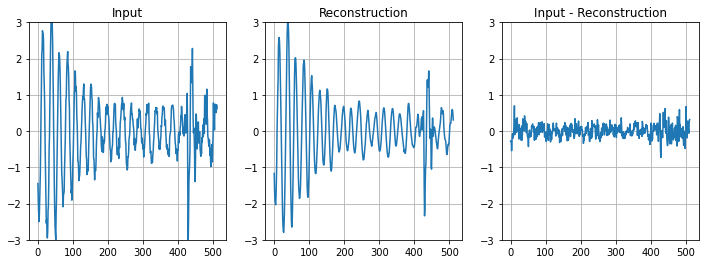

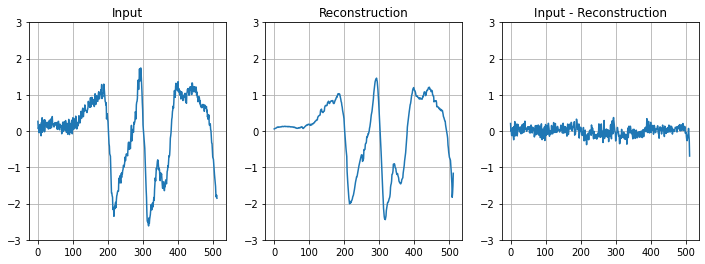

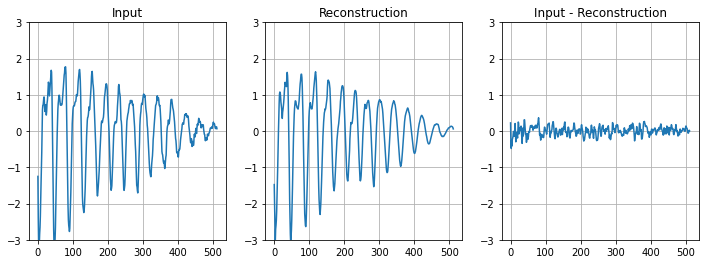

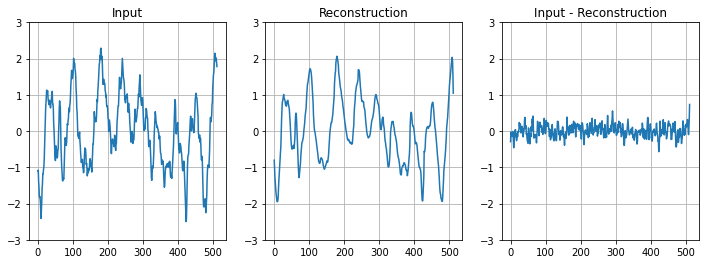

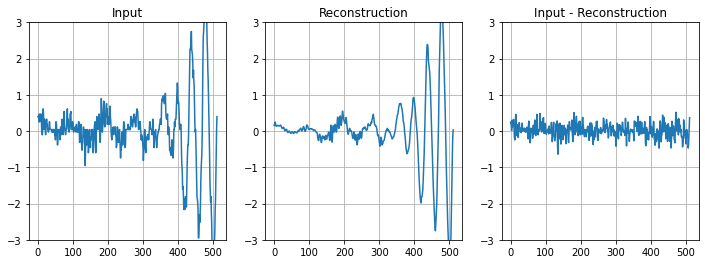

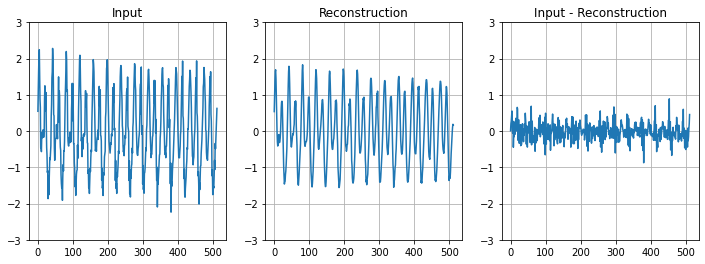

In [34]:
for i in range(15):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].plot(inputs[i, 0].cpu().numpy())
    axs[1].plot(recon.cpu().numpy()[i, 0])
    axs[2].plot(recon_error[i, 0].cpu().numpy())
    axs[0].set_title('Input')
    axs[1].set_title('Reconstruction')
    axs[2].set_title('Input - Reconstruction')

    for ax in axs:
        ax.set_ylim(-3, 3)
        ax.grid()

    plt.show()
    plt.close()